# Applied problem: Sequence of operations on images

In [1]:
import glob, os
from dask.distributed import Client
from dask import delayed
import skimage.io
import skimage.filters
import numpy as np
import matplotlib.pyplot as plt

A very common problem when dealing with image processing, is to have a set of images in a folder and having to apply a time-consuming operation on all of them.

Let's first get the names of all images:

In [2]:
filenames = glob.glob('../Data/BBBC032_v1_dataset/*.tif')
filenames

['../PyImageCourse/Data/BBBC032_v1_dataset/BMP4blastocystC2.tif',
 '../PyImageCourse/Data/BBBC032_v1_dataset/BMP4blastocystC3.tif',
 '../PyImageCourse/Data/BBBC032_v1_dataset/BMP4blastocystC1.tif',
 '../PyImageCourse/Data/BBBC032_v1_dataset/BMP4blastocystC0.tif']

Dask is not good at parsing filenames so we transform those into absolute paths:

In [ ]:
filenames = [os.path.abspath(f) for f in filenames]

We can import a single image using the ```io``` module of scikit-image:

In [3]:
image = skimage.io.imread(filenames[0])

In [4]:
image.shape

(172, 1344, 1024)

It is a quite large image representing volume data. Typical image filtering functions could be relatively slow on this especially with large kernels. We are going to do a gaussian filtering on only part of the image and then measure the mean value of the array:

In [24]:
%%time
image = skimage.io.imread(filenames[0])
filtered = skimage.filters.gaussian(image[0:40,:,:],0.1)
mean_val =np.mean(im)

CPU times: user 1.59 s, sys: 725 ms, total: 2.31 s
Wall time: 2.23 s


If we execute that function on all images we are obsiously going to spend about 1min on this. Let's try to make it faster using Dask:

In [9]:
client = Client()

In [11]:
client

Client Scheduler: tcp://127.0.0.1:62025 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [29]:
%%time
all_vals = []
for f in filenames:
    im = skimage.io.imread(f)
    im = skimage.filters.gaussian(im[0:40,:,:],0.1)
    mean_val = np.mean(im)
    all_vals.append(mean_val)
np.max(all_vals)

CPU times: user 6.91 s, sys: 2.61 s, total: 9.52 s
Wall time: 9.15 s


0.00791776016748083

In [30]:
all_vals = []
for f in filenames:
    im = delayed(skimage.io.imread)(f)
    im = delayed(skimage.filters.gaussian)(im[0:40,:,:],0.1)
    mean_val = delayed(np.mean)(im)
    all_vals.append(mean_val)
    

In [31]:
max_mean = delayed(np.max)(all_vals)

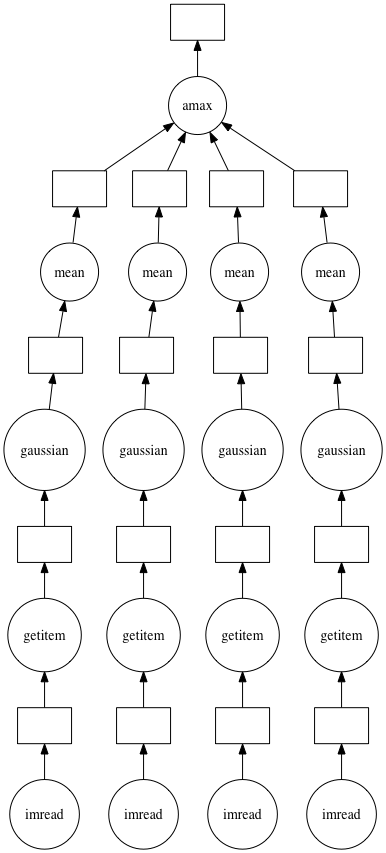

In [32]:
max_mean.visualize()

In [33]:
%%time
max_mean.compute()

CPU times: user 301 ms, sys: 24.4 ms, total: 325 ms
Wall time: 3.98 s


0.00791776016748083